# Function Calculators

In the [DiffPy-CMI](http://www.diffpy.org/products/diffpycmi/) framework the [diffpy.srreal](https://github.com/diffpy/diffpy.srreal) package provides the majority of features for evaluation of structure models and for simulation of structure-based physical quantities.  The diffpy.srreal calculators address physical quantities deriving from atom-pair interactions.  The calculators use the same procedure for iteration over atom pairs and a uniform interface to structure data.  As a result, the package can be easily extended with user-defined calculators or with support for additional structure representations.

The calculators available in diffpy.srreal include:

- BondCalculator - evaluation of bond distances
- BVSCalculator - evaluation of bond valence sums
- OverlapCalculator - calculation of atom overlaps asumming hard-sphere model
- PDFCalculator - calculation of PDF (atomic pair distribution function) using real-space summation
- DebyePDFCalculator - simulation of PDF from Debye scattering equation

This notebook gives an overview of the use and extensibility of the calculators in diffpy.srreal.

**Contents**

> [Calculation of bond distances](#Calculation-of-bond-distances)<br>
> [Basic and optimized evaluation](#Basic-and-optimized-evaluation)<br>
> [Parallel calculation](#Parallel-calculation)<br>
> [PDF calculators](#PDF-calculators)<br>
> [Calculator components and their customization](#Calculator-components-and-their-customization)<br>
> [Extending with more structure types](#Extending-with-more-structure-types)<br>
> [User-defined Lennard-Jones calculator](#User-defined-Lennard-Jones-calculator)<br>

## Calculation of bond distances

In [1]:
# notebook setup
%matplotlib notebook
from __future__ import print_function
from matplotlib.pyplot import subplots, rc
rc('figure', figsize=(6, 4.5))

# use several structure representations in DiffPy-CMI
from diffpy.Structure import loadStructure
from pyobjcryst.crystal import CreateCrystalFromCIF
# load NaCl CIF as diffpy.Structure and pyobjcryst.Crystal object
nacl_stru = loadStructure('NaCl.cif')
nacl_objc = CreateCrystalFromCIF(open('NaCl.cif'))

# create BondCalculator object
from diffpy.srreal.bondcalculator import BondCalculator
bc = BondCalculator(rmax=3)

# The bc calculator works with both structure representations
print(bc(nacl_stru))
print(bc(nacl_objc))

[ 2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81
  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81
  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81
  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81]
[ 2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81]


The returned distance arrays are of different lengths because *diffpy.Structure* works with an expanded unit cell.  The Python variable `bc` is an instance of the *BondCalculator* class.  There may be multiple instances of *BondCalculator* or any other calculator object, each with its own configuration and structure models.

In [2]:
# create two BondCalculators for Na-Na and Na-Cl pairs only
bcNaNa = BondCalculator(rmax=4.5)
bcNaNa.setTypeMask('Na1+', 'Na1+', True, others=False)
bcNaCl = BondCalculator(rmax=4.5)
bcNaCl.setTypeMask('Na1+', 'Cl1-', True, others=False)

print("Na-Na:", bcNaNa(nacl_objc))
print("Na-Cl:", bcNaCl(nacl_objc))

Na-Na: [ 3.97394011  3.97394011  3.97394011  3.97394011  3.97394011  3.97394011
  3.97394011  3.97394011  3.97394011  3.97394011  3.97394011  3.97394011]
Na-Cl: [ 2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81  2.81]


The *BondCalculator* object behaves like a function which takes a structure model as its argument and returns a sorted array of atom distances.  Additional details about the evaluated distances are thereafter available as calculator attributes.

In [3]:
tablerows = zip(bcNaCl.distances, bcNaCl.sites0, bcNaCl.sites1, 
                bcNaCl.types0, bcNaCl.types1, bcNaCl.directions)
for r in tablerows:
    print(*r)

2.81 0 1 Na1+ Cl1- [-2.81  0.    0.  ]
2.81 0 1 Na1+ Cl1- [ 0.   -2.81  0.  ]
2.81 0 1 Na1+ Cl1- [ 0.    0.   -2.81]
2.81 0 1 Na1+ Cl1- [ 0.    0.    2.81]
2.81 0 1 Na1+ Cl1- [ 0.    2.81  0.  ]
2.81 0 1 Na1+ Cl1- [ 2.81  0.    0.  ]
2.81 1 0 Cl1- Na1+ [-2.81  0.    0.  ]
2.81 1 0 Cl1- Na1+ [ 0.   -2.81  0.  ]
2.81 1 0 Cl1- Na1+ [ 0.    0.   -2.81]
2.81 1 0 Cl1- Na1+ [ 0.    0.    2.81]
2.81 1 0 Cl1- Na1+ [ 0.    2.81  0.  ]
2.81 1 0 Cl1- Na1+ [ 2.81  0.    0.  ]


A brief description of the functions and attributes in the *BondCalculator* class is available in its Python docstring and also in the package documentation at http://diffpy.github.io/diffpy.srreal.

In [4]:
help(BondCalculator)

Help on class BondCalculator in module diffpy.srreal.srreal_ext:

class BondCalculator(BasePairQuantity)
 |  Calculator of bond distances in a specified structure.
 |  
 |  Method resolution order:
 |      BondCalculator
 |      BasePairQuantity
 |      Attributes
 |      Boost.Python.instance
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __call__ = _call_kwargs(self, structure=None, **kwargs)
 |      Return sorted bond distances in the specified structure.
 |      
 |      structure    -- structure to be evaluated, an instance of diffpy Structure
 |                      or pyobjcryst Crystal.  Reuse the last structure when None.
 |      kwargs       -- optional parameter settings for this calculator
 |      
 |      Return a sorted numpy array.
 |  
 |  __getstate__(...)
 |      __getstate__( (object)arg1) -> tuple :
 |      
 |          C++ signature :
 |              boost::python::tuple __getstate__(boost::python::api::object)
 |  
 |  __init__ = _init_kwargs(s

## Basic and optimized evaluation

The calculators in diffpy.srreal can be used in an *OPTIMIZED* mode, where pair contributions are evaluated only for atoms that have moved or otherwise changed since the last evaluation.  A full sum over all atom pairs is then carried only for the first evaluation of a structure or when the structure model changes significantly.  The *BASIC* mode performs a full sum every time.  The actual evaluation mode that was used is indicated with the *evaluatortypeused* attribute.

In [5]:
from diffpy.srreal.pdfcalculator import PDFCalculator

nacl_stru.Bisoequiv = 0.5
pdfc = PDFCalculator(rmax=10)
pdfc.evaluatortype = 'OPTIMIZED'
r, g = pdfc(nacl_stru)
print("first evaluation:", pdfc.evaluatortypeused)
r, g = pdfc(nacl_stru)
print("second evaluation:", pdfc.evaluatortypeused)

first evaluation: BASIC
second evaluation: OPTIMIZED


When calculator objects are run with no arguments they reevaluate the last structure.  Here we use this for a simple benchmark of the BASIC and OPTIMIZED calculation modes.

In [6]:
pdfc.evaluatortype = 'BASIC'
%timeit pdfc()
pdfc.evaluatortype = 'OPTIMIZED'
%timeit pdfc()

100 loops, best of 3: 2.96 ms per loop
The slowest run took 64.85 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 45.8 µs per loop


## Parallel calculation

The calculations in diffpy.srreal can also be sped up by evaluating the atom pairs in parallel and then combining the partial results.  The parallel calculations are configured by specifying a template calculator, the number of partial tasks, and a parallel map function that distributes function calls among parallel workers.

The example below sets up 2 partial tasks, but uses the builtin *map* function which performs them in a sequence.  The calculation speed is thus not improved, but we can confirm the same result is obtained by combining 2 partial calculations.  If this notebook session is run with an active IPython cluster, remove the comment symbols to use the parallel *map* from the cluster and conduct a parallel evaluation for real.

<IPython.core.display.Javascript object>


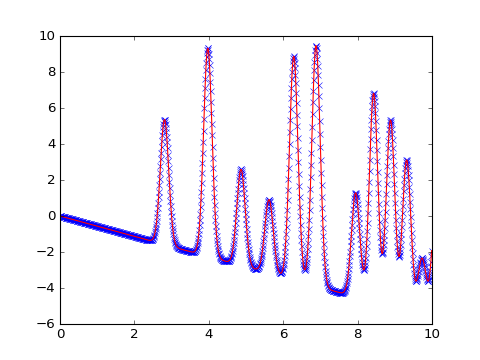

In [7]:
from diffpy.srreal.parallel import createParallelCalculator

pdfc0 = PDFCalculator()
pdfc2 = createParallelCalculator(PDFCalculator(), ncpu=2, pmap=map)
## uncomment to use parallel map from IPython parallel cluster
#from ipyparallel import Client
#engineview = Client()[:]
#pdfc2 = createParallelCalculator(PDFCalculator(), len(engineview), engineview.map)

# calculate PDF using serial and parallel calculator
r0, g0 = pdfc0(nacl_stru)
r2, g2 = pdfc2(nacl_stru)

# compare serial and parallel results
fig1, ax1 = subplots()
ax1.plot(r0, g0, 'x', r2, g2, '-r');

## PDF calculators

diffpy.srreal provides 2 methods for calculating PDFs:

- `PDFCalculator` - real-space summation of peak profiles suitable for periodic structures,
- `DebyePDFCalculator` - reciprocal-space evaluation of Debye sum with Fourier transformation to real space - preferred for finite clusters and atoms with different *Q*-dependencies of their scattering factors.

Here we demonstrate both calculators on an equally spaced chain of 10 atoms.

<IPython.core.display.Javascript object>


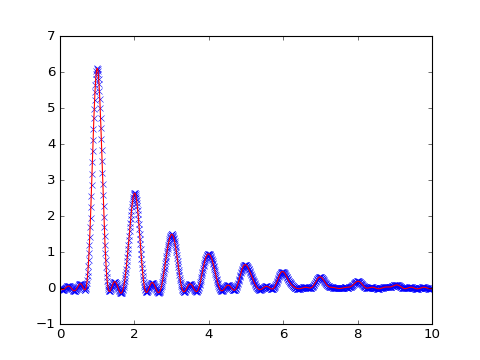

In [8]:
from diffpy.Structure import Structure, Atom

# generate a chain of atoms
c10 = Structure([Atom('C', (0, 0, z)) for z in range(10)])
c10.Bisoequiv = 0.5

# create PDF calculators per each method
from diffpy.srreal.pdfcalculator import PDFCalculator
from diffpy.srreal.pdfcalculator import DebyePDFCalculator

pdfc = PDFCalculator(qmax=18, rmax=10)
dbpdfc = DebyePDFCalculator(qmax=18, rmax=10)

# Try qmin=1.0 values to simulate low-Q bound in measured PDF.
qmin = 0
r0, g0 = pdfc(c10, qmin=qmin)
r2, g2 = dbpdfc(c10, qmin=qmin)

# compare results
fig2, ax2 = subplots()
ax2.plot(r0, g0, 'x', r2, g2, '-r');

## Calculator components and their customization

Calculator objects in diffpy.srreal are composed of other objects for specialized partial tasks, such as lookup of scattering factors or calculation of profile functions.  These objects can be reconfigured or replaced at runtime to tweak the calculation.  For example, a simulation of a neutron PDF is achieved by replacing the *ScatteringFactorTable* object attached to a PDFCalculator.

<IPython.core.display.Javascript object>


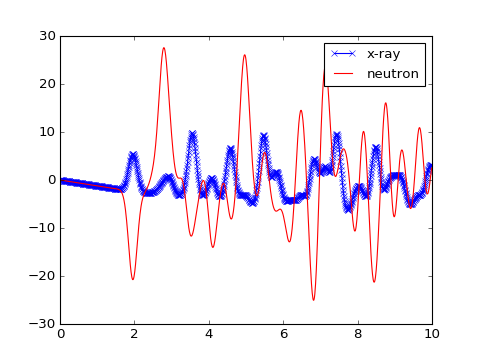

In [9]:
from diffpy.srreal.scatteringfactortable import SFTXray, SFTNeutron

rutile = loadStructure('TiO2_rutile.cif')
pcx = PDFCalculator()
pcx.scatteringfactortable = SFTXray()
pcn = PDFCalculator()
pcn.scatteringfactortable = SFTNeutron()

fig3, ax3 = subplots()
ax3.plot(*pcx(rutile), marker='x', label='x-ray')
ax3.plot(*pcn(rutile), color='red', label='neutron')
ax3.legend();

In addition to using the predefined objects, users can define their own components to further customize the calculation procedure.  As diffpy.srreal is a Python interface to the C++ library libdiffpy, the new components can be defined either in C++ or Python.  The example below defines a new rectangular peak profile for a real-space PDF calculation.

In [10]:
# New profiles must derive from a generic PeakProfile class.
from diffpy.srreal.peakprofile import PeakProfile

class RectangularProfile(PeakProfile):
    "Rectangular profile with a unit area."
    
    # override functions from the base PeakProfile class
    
    def __call__(self, x, fwhm):
        "Evaluate zero-centered profile at the given position and width."
        inside = (-fwhm/2.0 < x < +fwhm/2.0)
        y = (1.0 / fwhm) if inside else 0.0
        return y

    def clone(self):
        "Return a copy of this profile object."
        import copy
        return copy.copy(self)

    def create(self):
        "Return a new instance of this profile class."
        return RectangularProfile()

    def type(self):
        "Return a unique string name for this profile function."
        return "rectangularprofile"

    def xboundhi(self, fwhm):
        "Upper bound where profile becomes negligibly small."
        return +0.5 * fwhm

    def xboundlo(self, fwhm):
        "Lower bound where profile becomes negligibly small."
        return -0.5 * fwhm

The new `RectangularProfile` class can be added to a global registry of available profiles, so it can be specified by its string name.

In [11]:
# deregister to allow repeated evaluations
PeakProfile._deregisterType('rectangularprofile')
RectangularProfile()._registerThisType()
print(PeakProfile.getRegisteredTypes())

set(['rectangularprofile', 'croppedgaussian', 'gaussian'])


The new peak profile can now be set in the *PDFCalculator* function using either the *RectangularProfile* object or the register name.

In [12]:
pdfc = PDFCalculator()

pdfc.peakprofile = RectangularProfile()
print("Profile assigned by instance:", pdfc.peakprofile)

pdfc.peakprofile = 'rectangularprofile'
print("Profile assigned by name:", pdfc.peakprofile)

Profile assigned by instance: <__main__.RectangularProfile object at 0x11c4562b8>
Profile assigned by name: <__main__.RectangularProfile object at 0x11c598af8>


Finally, here is a plot of the PDF obtained with the new rectangular profile.

<IPython.core.display.Javascript object>


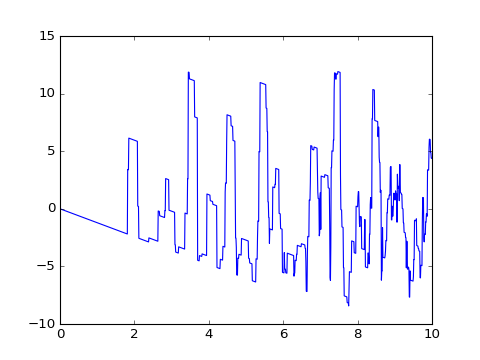

In [13]:
r, g = pdfc(rutile)
fig4, ax4 = subplots()
ax4.plot(r, g);

## Extending with more structure types

The calculators in diffpy.srreal can use either the diffpy.Structure or pyobjcryst structure representations.  In detail, both of these types are converted to a native StructureAdapter class, which is understood by the calculation internals.  Structure objects from other crystallographic packages can thus be readily supported by providing appropriate conversion functions.

Here we define a very simple structure class and then make it work with all calculators in diffpy.srreal.  The example structure type *CarbonChain* stores only the *z* coordinate of carbon atoms and their common isotropic displacement parameter Uiso.

In [14]:
class CarbonChain(object):
    def __init__(self):
        self.Uiso = 0.004
        self.z = []

Next we define a converter function, which builds a compatible adapter from a CarbonChain object.  The converter function is declared using the *@RegisterStructureAdapter* decorator and a dotted Python name of the converted class.

In [15]:
from diffpy.srreal.structureconverters import RegisterStructureAdapter

@RegisterStructureAdapter('__main__.CarbonChain')
def convertCarbonChain(thechain):
    # AtomicStructureAdapter is a simple collection of atom positions
    from diffpy.srreal.structureadapter import AtomicStructureAdapter
    from diffpy.srreal.structureadapter import Atom as AdptAtom
    adpt = AtomicStructureAdapter()
    a = AdptAtom()
    a.atomtype = 'C'
    a.uc11 = a.uc22 = a.uc33 = thechain.Uiso
    for z in thechain.z:
        a.zc = z
        adpt.append(a)
    return adpt

We can now test it with the *createStructureAdapter* function to verify that the conversion works.

In [16]:
from diffpy.srreal.structureadapter import createStructureAdapter

c5 = CarbonChain()
c5.z = range(5)
createStructureAdapter(c5)

If there were no error messages, the CarbonChain class is convertible to an adapter and can be directly used with any of the diffpy.srreal calculators.

In [17]:
# calculate bond distances in the c5 CarbonChain
bc = BondCalculator()
bc(c5)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        2.,  3.,  3.,  3.,  3.,  4.,  4.])

<IPython.core.display.Javascript object>


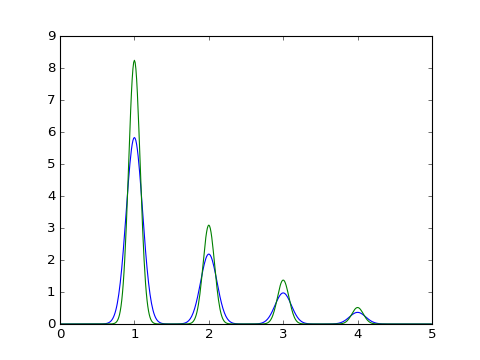

In [18]:
# calculate PDF for the c5 chain
pdfc = PDFCalculator(rmax=5)
c5.Uiso = 0.006
fig5, ax5 = subplots()
ax5.plot(*pdfc(c5))
c5.Uiso = 0.003
ax5.plot(*pdfc(c5));

## User-defined Lennard-Jones calculator

All calculator objects in diffpy.srreal are derived from the base *PairQuantity* class and use the same procedures for iteration over atom pairs.  Users can define their own calculators for pair-interaction related quantities by deriving from the `PairQuantity` class and modifying just the function which processes pair contributions.  

As an example we define a class that calculates the Lennard-Jones potential, where the energy contribution from each atom pair is
$$
V_{\mathit{LJ}} = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} -
\left(\frac{\sigma}{r}\right)^{6} \right]
$$

In [19]:
from diffpy.srreal.pairquantity import PairQuantity

class LennardJonesCalculator(PairQuantity):

    # parameters in the LJ formula
    epsilon = 1.0
    sigma = 1.0

    # override functions from the PairQuantity class
    
    def __init__(self):
        PairQuantity.__init__(self)
        self.rmax = 10
        return
    
    def _resetValue(self):
        'Clear old results at the beginning of evaluation.'
        self._vljtotal = 0.0
        return

    def _addPairContribution(self, bond, sumscale):
        '''Process contribution from one atom pair.

        bond     -- BaseBondGenerator object that describes the
                    current pair of atom sites.
        sumscale -- multiplicity of the current atom pair.
        '''
        nmrij = bond.distance() / self.sigma
        vij = 4 * self.epsilon * (nmrij ** -12  -  nmrij ** -6)
        self._vljtotal += 0.5 * vij * sumscale
        return

    def __call__(self, structure=None):
        'Return LJ potential for the specified structure.'
        self.eval(structure)
        return self._vljtotal

The new *LennardJonesCalculator* is aware of all structure conversions just as the pre-defined calculators.  Thus, we can try it out on the 5-atom *CarbonChain* object `c5`.

In [20]:
ljcalc = LennardJonesCalculator()
print("ljcalc(c5) =", ljcalc(c5))
ljcalc.epsilon = 2
print("Recalculate with LJ epsilon =", ljcalc.epsilon)
print("ljcalc() =", ljcalc())

ljcalc(c5) = -0.19650552007
Recalculate with LJ epsilon = 2
ljcalc() = -0.39301104014


---

For more information about the diffpy.srreal package see http://www.diffpy.org/diffpy.srreal.